In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xlrd

Data Kejadian Tuberkulosis Preparation

In [2]:
df_excel = pd.read_excel('/Users/Jia/Downloads/data_skripsi/tb/data_tb.xlsx')

In [3]:
# Mengonversi kolom 'time' ke tipe data datetime
df_excel['time'] = pd.to_datetime(df_excel['time'])

# Menambahkan kolom 'month'
df_excel['month'] = df_excel['time'].dt.month

# Menambahkan kolom 'year'
df_excel['year'] = df_excel['time'].dt.year

In [4]:
df_excel

,KABKOT,month,year,tb,longitude,latitude,time
0,JAKARTA BARAT,1,2018,773,106.750000,-6.158333,2018-01-01
1,JAKARTA BARAT,2,2018,606,106.750000,-6.158333,2018-02-01
2,JAKARTA BARAT,3,2018,721,106.750000,-6.158333,2018-03-01
3,JAKARTA BARAT,4,2018,761,106.750000,-6.158333,2018-04-01
4,JAKARTA BARAT,5,2018,737,106.750000,-6.158333,2018-05-01
...,...,...,...,...,...,...,...
295,JAKARTA UTARA,8,2022,749,106.891667,-6.125000,2022-08-01
296,JAKARTA UTARA,9,2022,786,106.891667,-6.125000,2022-09-01
297,JAKARTA UTARA,10,2022,833,106.891667,-6.125000,2022-10-01
298,JAKARTA UTARA,11,2022,741,106.891667,-6.125000,2022-11-01


Spatial Join df and gdf

In [5]:
# Load shapefile into a GeoDataFrame
gdf_shapefile = gpd.read_file(r"/Users/Jia/Downloads/data_skripsi/kota_DKIJakarta/Kota_DKIJakarta.shp")

In [6]:
# Convert DataFrame to GeoDataFrame
geometry = gpd.points_from_xy(df_excel['longitude'], df_excel['latitude'])
gdf_excel = gpd.GeoDataFrame(df_excel, geometry=geometry, crs="EPSG:4326")

<Axes: >

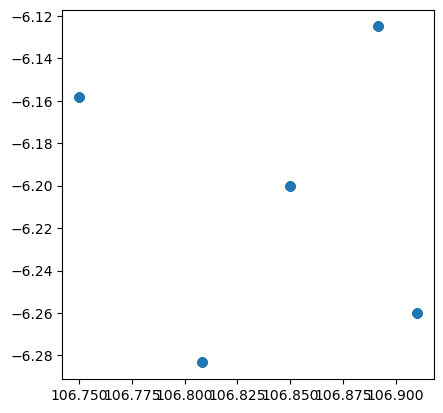

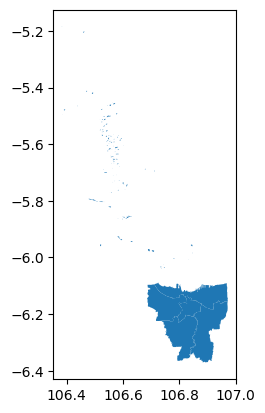

In [7]:
gdf_excel.plot()
gdf_shapefile.plot()

In [8]:
# spatial join
result = gdf_excel.merge(gdf_shapefile, on = 'KABKOT')
result['geometry'] = result['geometry_y']
result = gpd.GeoDataFrame(result)
result_pop = result[['longitude', 'latitude', 'tb', 'month', 'year', 'KABKOT', 'geometry', 'time']]

In [9]:
# Identify rows in gdf_excel that don't have a match in the result
non_matching_rows = gdf_excel[~gdf_excel.index.isin(result.index)]
print(non_matching_rows)

Empty GeoDataFrame
Columns: [KABKOT, month, year, tb, longitude, latitude, time, geometry]
Index: []


Axes(0.220549,0.11;0.583903x0.77)
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   longitude  300 non-null    float64       
 1   latitude   300 non-null    float64       
 2   tb         300 non-null    int64         
 3   month      300 non-null    int32         
 4   year       300 non-null    int32         
 5   KABKOT     300 non-null    object        
 6   geometry   300 non-null    geometry      
 7   time       300 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), geometry(1), int32(2), int64(1), object(1)
memory usage: 16.5+ KB
None


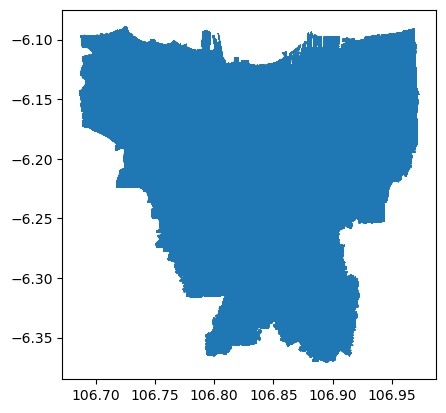

In [10]:
print(result_pop.plot())
print(result_pop.info())

Dissolved Result (year)

In [11]:
# Dissolve berdasarkan 'KABKOT' dan 'month' dengan fungsi agregasi mean
dissolved_result = result_pop.dissolve(by=['KABKOT', 'month', 'year'])

# Reset indeks untuk membuat kolom 'KABKOT' 'month', dan 'year' menjadi kolom
dissolved_result.reset_index(inplace=True)

In [12]:
print(dissolved_result.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   KABKOT     300 non-null    object        
 1   month      300 non-null    int32         
 2   year       300 non-null    int32         
 3   geometry   300 non-null    geometry      
 4   longitude  300 non-null    float64       
 5   latitude   300 non-null    float64       
 6   tb         300 non-null    int64         
 7   time       300 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), geometry(1), int32(2), int64(1), object(1)
memory usage: 16.5+ KB
None


In [13]:
# Tampilkan hasil
dissolved_result.head()

,KABKOT,month,year,geometry,longitude,latitude,tb,time
0,JAKARTA BARAT,1,2018,"POLYGON Z ((106.71133 -6.09591 0.00000, 106.71...",106.75,-6.158333,773,2018-01-01
1,JAKARTA BARAT,1,2019,"POLYGON Z ((106.71133 -6.09591 0.00000, 106.71...",106.75,-6.158333,746,2019-01-01
2,JAKARTA BARAT,1,2020,"POLYGON Z ((106.71133 -6.09591 0.00000, 106.71...",106.75,-6.158333,745,2020-01-01
3,JAKARTA BARAT,1,2021,"POLYGON Z ((106.71133 -6.09591 0.00000, 106.71...",106.75,-6.158333,420,2021-01-01
4,JAKARTA BARAT,1,2022,"POLYGON Z ((106.71133 -6.09591 0.00000, 106.71...",106.75,-6.158333,913,2022-01-01


In [14]:
dissolved_result_df = pd.DataFrame(dissolved_result.drop(['geometry'],axis = 1))
#dissolved_result_df = dissolved_result_df.drop(['geometry'], axis=1) #kolom geometry di hapus

In [15]:
#untuk mengurutkan file berdasarkan
dissolved_result_df = dissolved_result_df.sort_values(by=[ 'year', 'KABKOT', 'month'])

In [16]:
dissolved_result_df

,KABKOT,month,year,longitude,latitude,tb,time
0,JAKARTA BARAT,1,2018,106.750000,-6.158333,773,2018-01-01
5,JAKARTA BARAT,2,2018,106.750000,-6.158333,606,2018-02-01
10,JAKARTA BARAT,3,2018,106.750000,-6.158333,721,2018-03-01
15,JAKARTA BARAT,4,2018,106.750000,-6.158333,761,2018-04-01
20,JAKARTA BARAT,5,2018,106.750000,-6.158333,737,2018-05-01
...,...,...,...,...,...,...,...
279,JAKARTA UTARA,8,2022,106.891667,-6.125000,749,2022-08-01
284,JAKARTA UTARA,9,2022,106.891667,-6.125000,786,2022-09-01
289,JAKARTA UTARA,10,2022,106.891667,-6.125000,833,2022-10-01
294,JAKARTA UTARA,11,2022,106.891667,-6.125000,741,2022-11-01


In [17]:
polygon_result = gpd.sjoin(gdf_shapefile, dissolved_result, how='inner', predicate='intersects')

In [18]:
print(polygon_result.columns)

Index(['PROVNO', 'KABKOTNO', 'PROVINSI', 'KABKOT_left', 'geometry',
       'index_right', 'KABKOT_right', 'month', 'year', 'longitude', 'latitude',
       'tb', 'time'],
      dtype='object')


Peta Spasial Jumlah per Bulan Tahun 2018-2022

In [19]:
import calendar

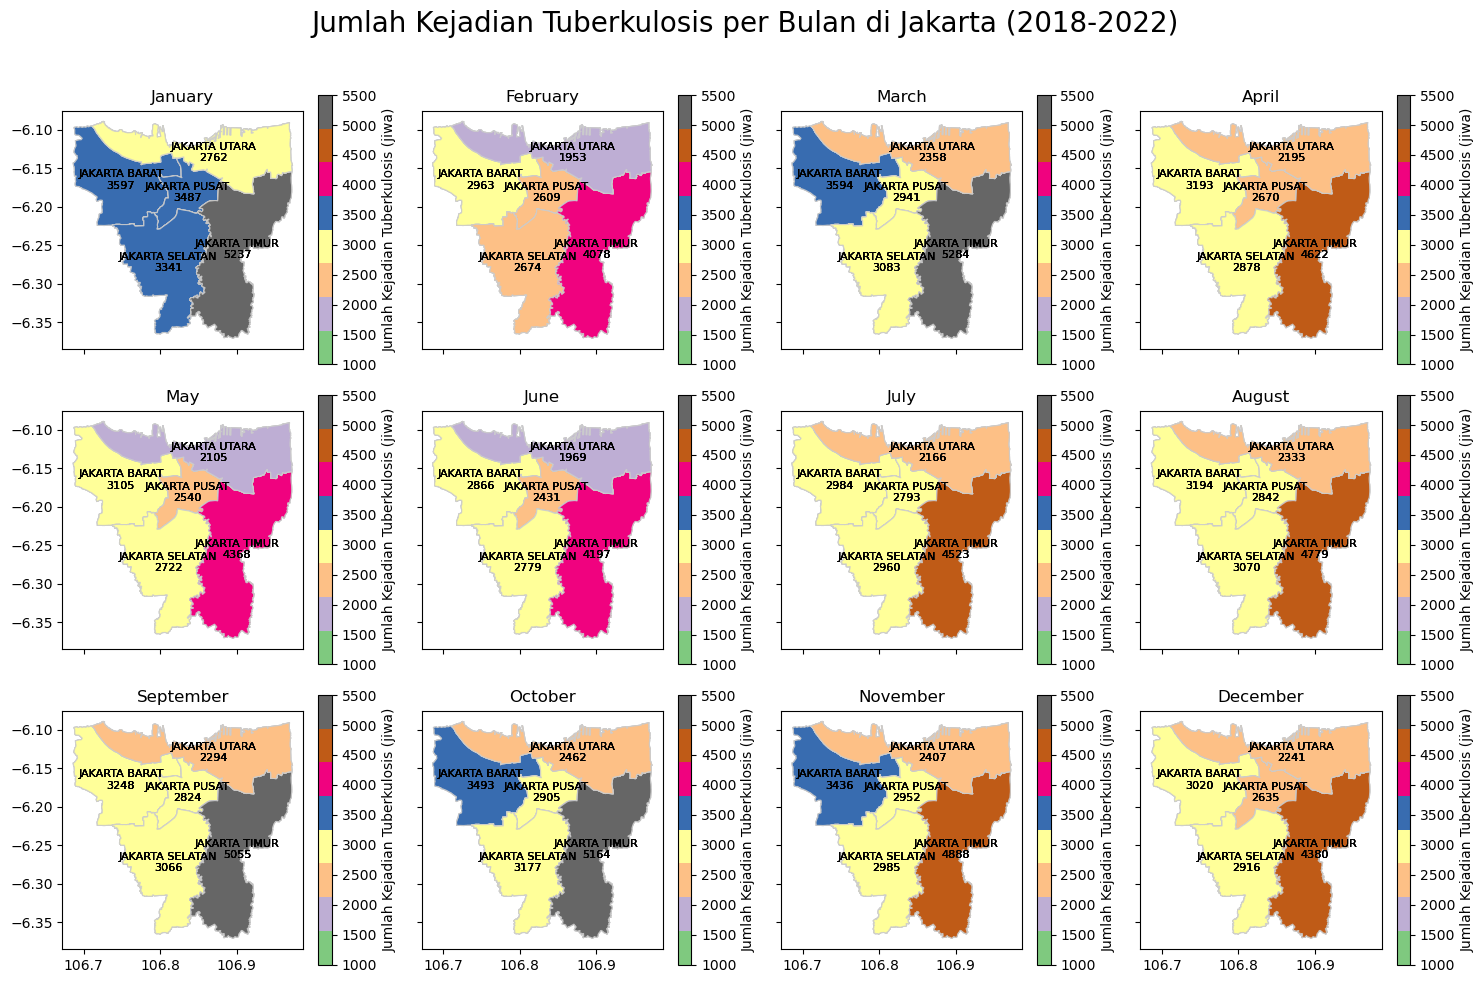

In [40]:
# Filter data for the years 2018 to 2022
data_2018_2022 = dissolved_result[(dissolved_result['year'] >= 2018) & (dissolved_result['year'] <= 2022)]

# Create a figure with subplots for each month
fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Jumlah Kejadian Tuberkulosis per Bulan di Jakarta (2018-2022)', fontsize=20)

# Iterate through each month and plot the data for the years 2018 to 2022
for month, ax in zip(range(1, 13), axs.flatten()):
    # Filter data for the current month and years 2018 to 2022
    data_monthly = data_2018_2022[data_2018_2022['month'] == month]

    # Calculate the total TB cases for each Kabupaten/Kota for the current month
    total_tb_per_kabkot = data_monthly.groupby(['KABKOT'])['tb'].sum().reset_index()

    # Merge the total TB cases back to the GeoDataFrame for the current month
    data_monthly_total_tb = data_monthly.merge(total_tb_per_kabkot, on='KABKOT', how='left', suffixes=('_original', '_total'))

    # Plot the map for the current month
    data_monthly_total_tb.plot(ax=ax, column="tb_total", legend=True, legend_kwds={"label": "Jumlah Kejadian Tuberkulosis (jiwa)"},
                               vmin=1000, vmax=5500, cmap="Accent", linewidth=0.8, edgecolor="0.8", alpha=0.8)

    # Annotate each polygon with total TB cases value
    for idx, row in data_monthly_total_tb.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['KABKOT']}\n{row['tb_total']:.0f}", fontsize=8, ha='center', va='center')
    ax.set_title(calendar.month_name[month])  # Using calendar module to get the month name

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

cmap = plt.get_cmap('Accent')
plt.set_cmap(cmap)

# Show the plot
plt.show()

Grafik Siklus Bulanan Kejadian Tuberkulosis Tahun 2018-2022

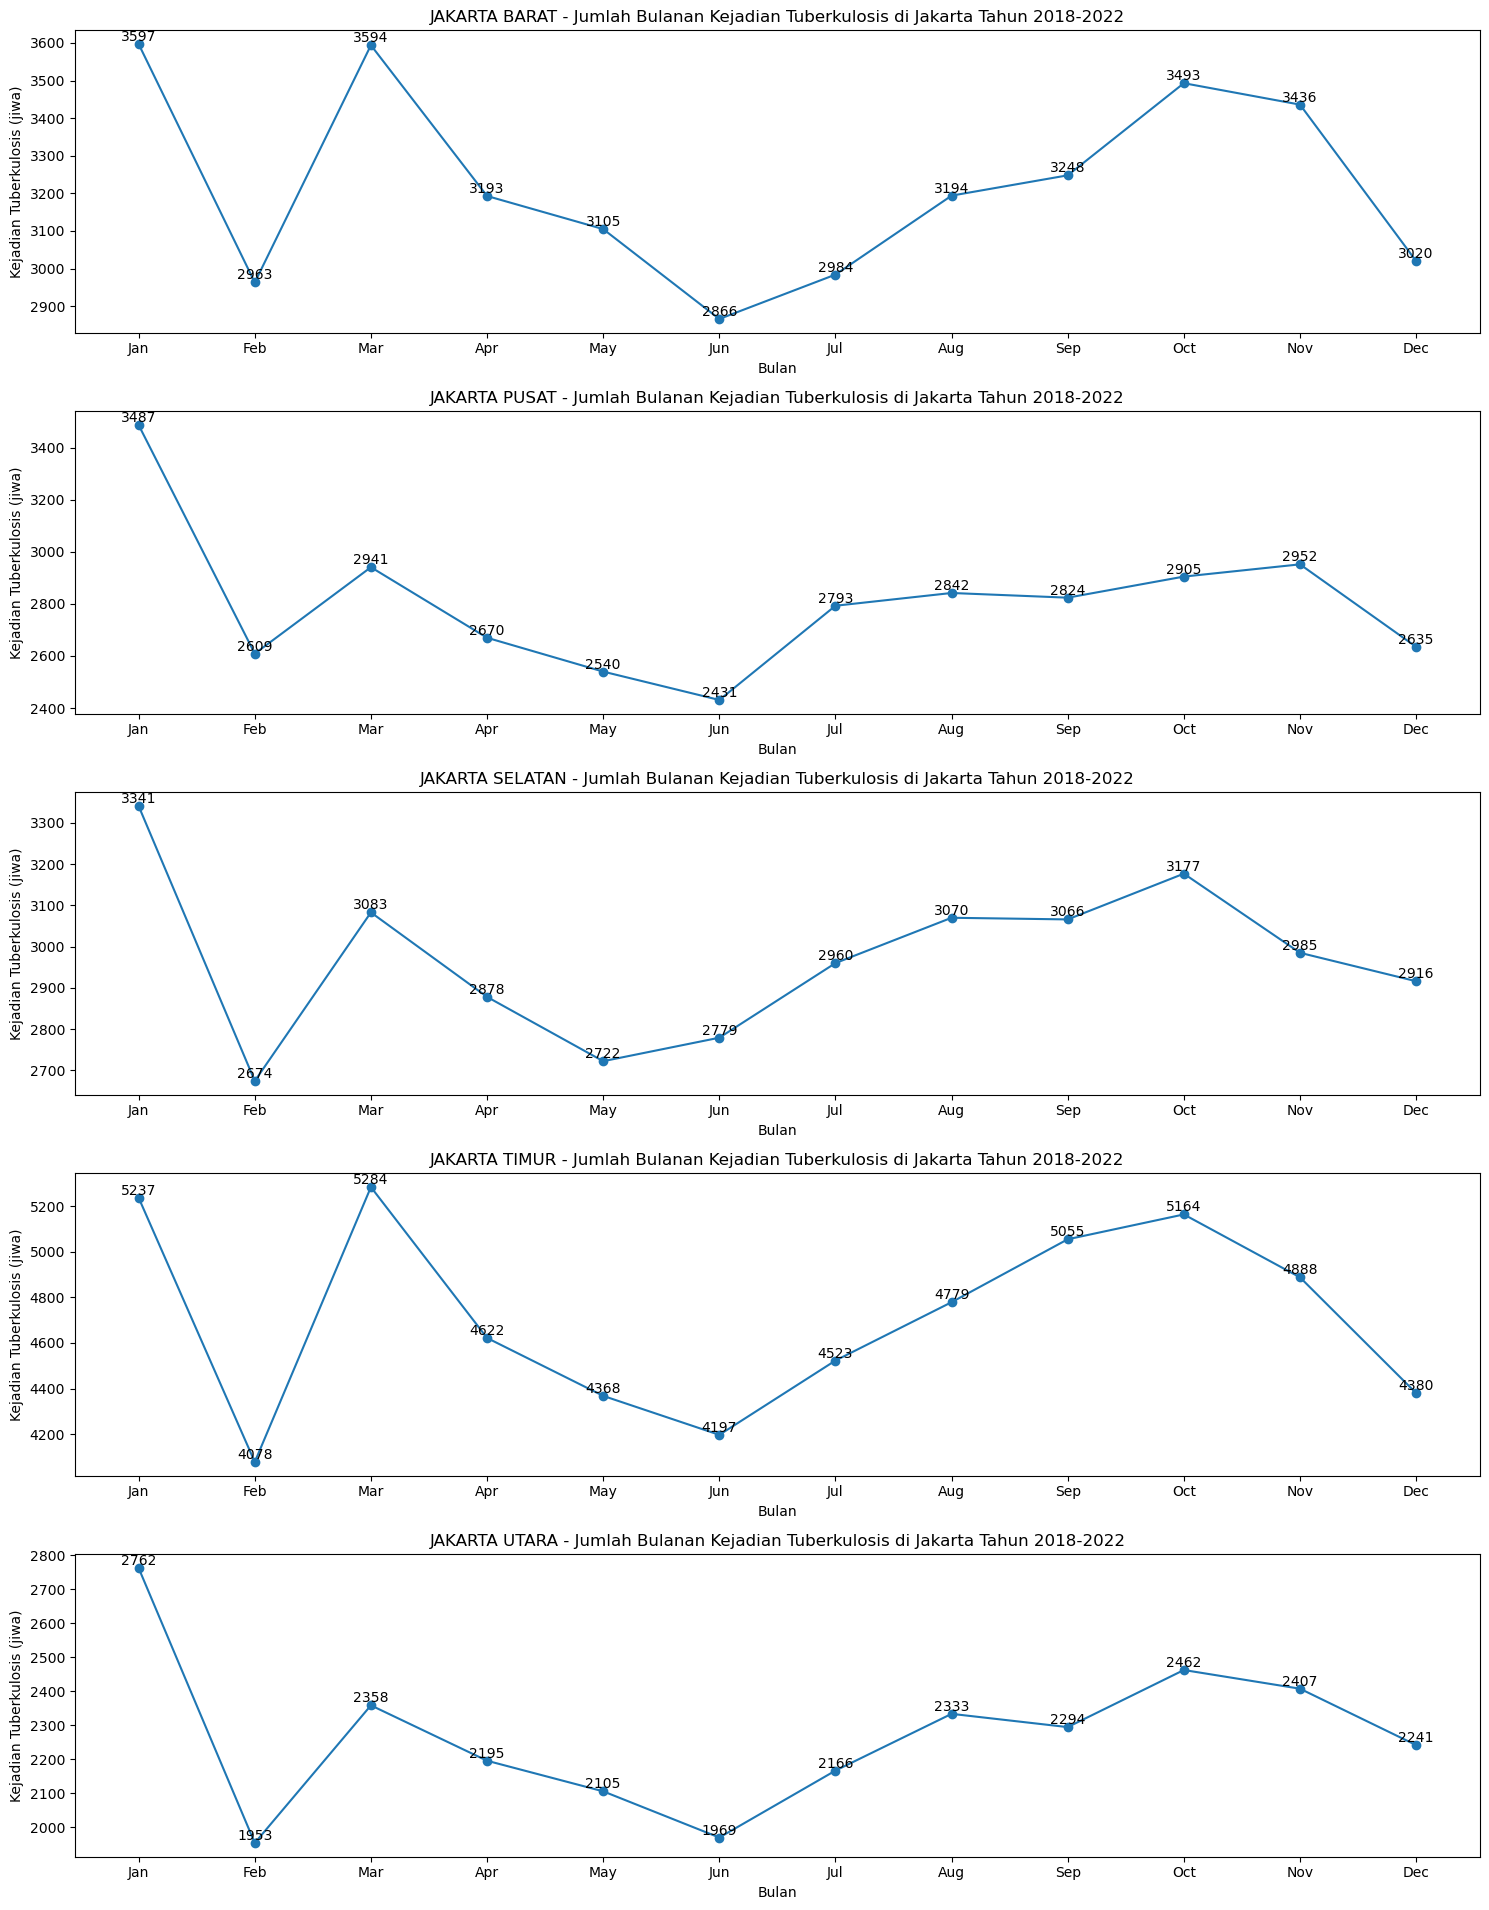

In [22]:
# Filter data for the years 2020 to 2022
data_2018_2022 = dissolved_result_df[(dissolved_result_df['year'] >= 2018) & (dissolved_result_df['year'] <= 2022)]

# Create a figure with subplots for each city
fig = plt.figure(figsize=(15, 20))
cities = list(data_2018_2022['KABKOT'].unique())

# Iterate through each city and plot the total TB cases for the years 2018 to 2022
for idx, city in enumerate(cities, start=1):
    # Filter data for the current city and years 2018 to 2022
    data_city_2018_2022 = data_2018_2022[data_2018_2022['KABKOT'] == city]

    # Calculate the monthly averages
    monthly_total = data_city_2018_2022.groupby('month')['tb'].sum()

    # Plot the map for the current city
    plt.subplot(len(cities), 1, idx)
    plt.plot(monthly_total, marker='o')
    plt.title(f'{city} - Jumlah Bulanan Kejadian Tuberkulosis di Jakarta Tahun 2018-2022')
    plt.xlabel('Bulan')
    plt.ylabel('Kejadian Tuberkulosis (jiwa)')
    plt.xticks(range(1, 13), [calendar.month_abbr[i] for i in range(1, 13)])  # Display month names

    # Add text with total TB cases on each data point
    for x, y in zip(range(1, 13), monthly_total):
        plt.text(x, y, f'{y:.0f}', ha='center', va='bottom')
        
# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

In [23]:
dissolved_result_df

,KABKOT,month,year,longitude,latitude,tb,time
0,JAKARTA BARAT,1,2018,106.750000,-6.158333,773,2018-01-01
5,JAKARTA BARAT,2,2018,106.750000,-6.158333,606,2018-02-01
10,JAKARTA BARAT,3,2018,106.750000,-6.158333,721,2018-03-01
15,JAKARTA BARAT,4,2018,106.750000,-6.158333,761,2018-04-01
20,JAKARTA BARAT,5,2018,106.750000,-6.158333,737,2018-05-01
...,...,...,...,...,...,...,...
279,JAKARTA UTARA,8,2022,106.891667,-6.125000,749,2022-08-01
284,JAKARTA UTARA,9,2022,106.891667,-6.125000,786,2022-09-01
289,JAKARTA UTARA,10,2022,106.891667,-6.125000,833,2022-10-01
294,JAKARTA UTARA,11,2022,106.891667,-6.125000,741,2022-11-01


Grafik Timetrend Series

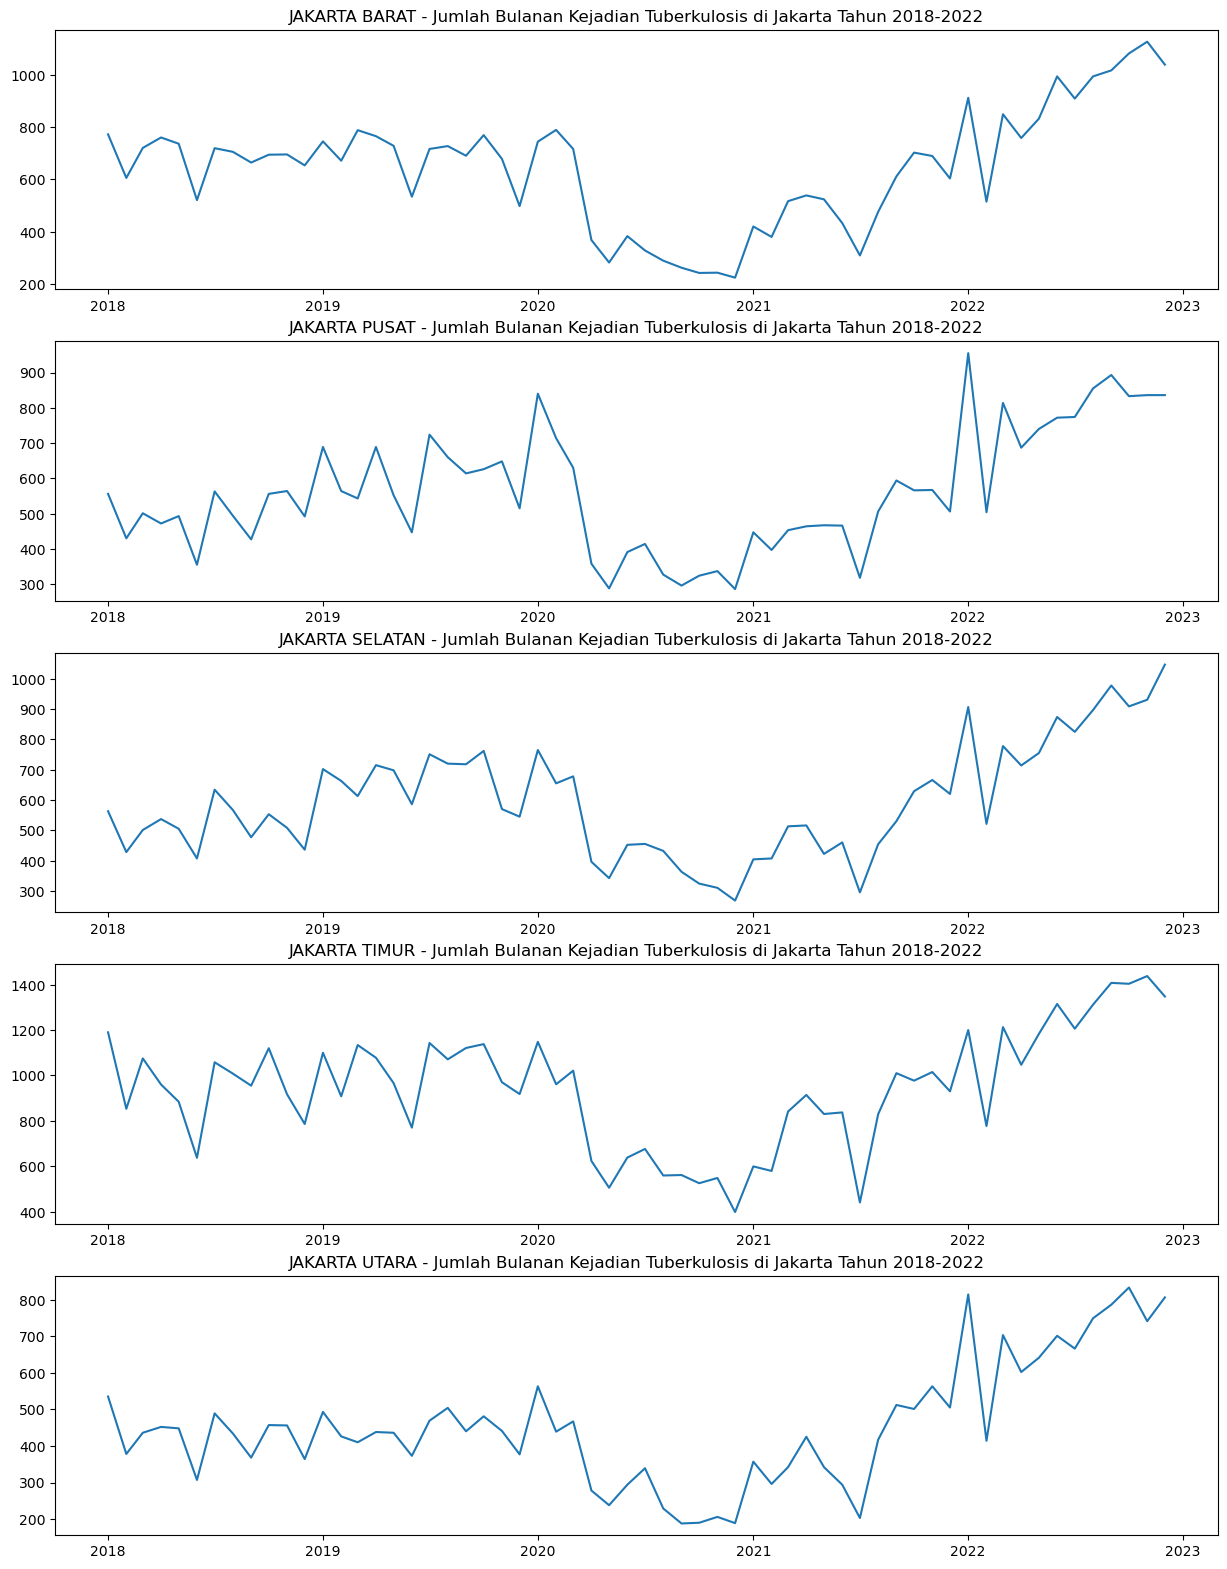

In [24]:
import calendar

fig  = plt.figure(figsize=(15,60))
cities = list(dissolved_result_df['KABKOT'].unique())
dissolved_result_df = dissolved_result_df.set_index('time')

# Iterate through each month and plot the data
for city, ax in zip(cities, range(1,6)):
    # Filter data for the current wilayah admin
    data_city = dissolved_result_df[dissolved_result_df['KABKOT'] == city]

    # Plot the map for the current kabkot
    fig.add_subplot(15, 1, ax)
    plt.plot(data_city['tb']) 
    plt.plot(marker='o')
    plt.title(f'{city} - Jumlah Bulanan Kejadian Tuberkulosis di Jakarta Tahun 2018-2022')
    #ax.set_title(f'{city}')

Analisis Univariat

In [25]:
total_tb_month_year = dissolved_result.groupby(['year', 'month'], as_index=False)['tb'].sum()
total_tb_month_year

,year,month,tb
0,2018,1,3617
1,2018,2,2695
2,2018,3,3234
3,2018,4,3182
4,2018,5,3067
5,2018,6,2227
6,2018,7,3464
7,2018,8,3209
8,2018,9,2892
9,2018,10,3381


In [27]:
#total_tb_month_year.to_excel("/Users/Jia/Downloads/data_skripsi/tb_year_sum.xlsx")

In [37]:
# sum per tahun
tb_year_sum = dissolved_result.groupby(['year'], as_index=False)['tb'].sum()

tb_year_sum

,year,tb
0,2018,36841
1,2019,41238
2,2020,27301
3,2021,32432
4,2022,53981


In [28]:
tb_sum_5years = total_tb_month_year ['tb'].sum()
tb_sum_5years

191793

In [29]:
#nilai min
tb_min_5years = total_tb_month_year ['tb'].min()
tb_min_5years

1365

In [30]:
#nilai max
tb_max_5years = total_tb_month_year ['tb'].max()
tb_max_5years

5083

In [32]:
# nilai min and max per kabkot 5 tahun
monthly_total = dissolved_result_df.groupby(['KABKOT', 'month'], as_index=False)['tb'].sum()

# Nilai minimum
min_row = monthly_total.loc[monthly_total['tb'].idxmin()]
min_location = min_row['KABKOT']
min_month = min_row['month']
min_value = min_row['tb']

# Nilai maksimum
max_row = monthly_total.loc[monthly_total['tb'].idxmax()]
max_location = max_row['KABKOT']
max_month = max_row['month']
max_value = max_row['tb']

# Menampilkan hasil
print(f"TB min = {min_value}, {min_location}, {min_month}.")
print(f"TB max = {max_value},{max_location}, {max_month}.")

TB min = 1953, JAKARTA UTARA, 2.
TB max = 5284,JAKARTA TIMUR, 3.


In [33]:
#sum kabkot 5 years

sum_kabkot = dissolved_result_df.groupby(['KABKOT'], as_index=False)['tb'].sum()

sum_kabkot_sorted = sum_kabkot.sort_values(by='tb', ascending=False)
print(sum_kabkot_sorted)

            KABKOT     tb
3    JAKARTA TIMUR  56575
0    JAKARTA BARAT  38693
2  JAKARTA SELATAN  35651
1    JAKARTA PUSAT  33629
4    JAKARTA UTARA  27245


(-)

In [35]:
#fig  = plt.figure(figsize=(15,60))
#cities = list(dissolved_result_df['KABKOT'].unique())

#import matplotlib.dates as mdates
#from matplotlib.axis import Axis

# Iterate through each month and plot the data
#for city, ax in zip(cities, range(1,6)):
    # Filter data for the current wilayah admin
#    data_city = dissolved_result_df[dissolved_result_df['KABKOT'] == city]

    # Plot the map for the current kabkot
#    axes = fig.add_subplot(15, 1, ax)
#    plt.plot(data_city['tb'])
#    axes.xaxis.set_major_locator(mdates.YearLocator())
#   axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#    plt.title(city)

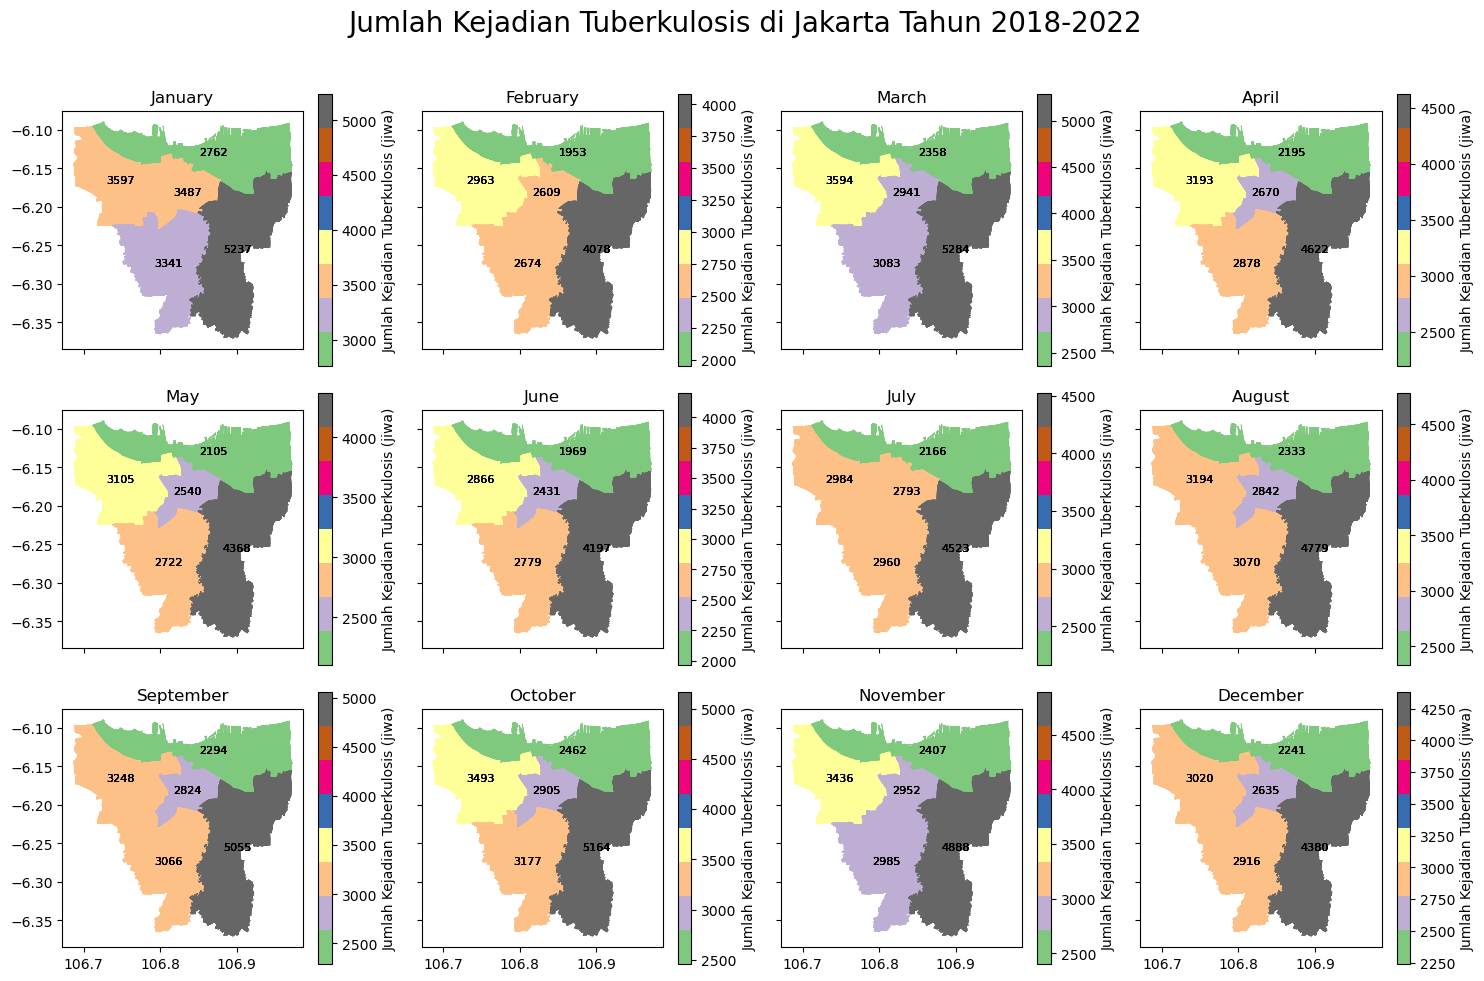

In [34]:
# Filter data for the years 2018 to 2022
data_2018_2022 = dissolved_result[(dissolved_result['year'] >= 2018) & (dissolved_result['year'] <= 2022)]

# Create a figure with subplots for each month
fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Jumlah Kejadian Tuberkulosis di Jakarta Tahun 2018-2022', fontsize=20)

# Iterate through each month and plot the data for the years 2018 to 2022
for month, ax in zip(range(1, 13), axs.flatten()):
    # Filter data for the current month and years 2018 to 2022
    data_monthly = data_2018_2022[data_2018_2022['month'] == month]

    # Calculate the total TB cases for each Kabupaten/Kota for the current month
    total_tb_per_kabkot = data_monthly.groupby(['KABKOT'])['tb'].sum().reset_index()

    # Merge the total TB cases back to the GeoDataFrame for the current month
    data_monthly_total_tb = data_monthly.merge(total_tb_per_kabkot, on='KABKOT', how='left', suffixes=('_original', '_total'))

    # Plot the map for the current month
    data_monthly_total_tb.plot(ax=ax, column="tb_total", legend=True, legend_kwds={"label": "Jumlah Kejadian Tuberkulosis (jiwa)"})

    # Annotate each polygon with total TB cases value
    for idx, row in data_monthly_total_tb.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['tb_total']:.0f}", fontsize=8, ha='center', va='center')

    ax.set_title(calendar.month_name[month])  # Using calendar module to get the month name

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

cmap = plt.get_cmap('Accent')
plt.set_cmap(cmap)

# Show the plot
plt.show()